# Biomedical Data Classification with ML and GAN-based Augmentation

This notebook demonstrates a full workflow for biomedical or clinical data classification.  
It combines:

- Classical **Machine Learning** models (Logistic Regression, Random Forest, XGBoost).
- A **GAN-based Autoencoder** for synthetic data generation.
- Preprocessing, imputation, scaling, training, validation, and performance evaluation.

Each step is documented to support understanding and reuse.

# A. End-to-End Signal Processing and GAN-Based Data Preparation Workflow

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Loading and Cleaning

In this section we:

- Load the CSV file containing vital-sign measurements.
- Select the relevant columns:
  - Heart Rate
  - Respiratory Rate
  - Person Presence Status
- Clean missing or invalid values and convert them to numeric format.
- Standardize units and filter the dataset to keep only samples where a person is detected.

In [ ]:
# Cargar el archivo CSV
file_path = '/content/vitalSignsData_0_780.csv'
data = pd.read_csv(file_path)

## 2. Thresholding and Label Definition

Here we:

- Define normal physiological ranges for heart rate and respiratory rate.
- Create binary indicators:
  - `out_of_range_hr` → 1 if HR is outside the defined range.
  - `out_of_range_rr` → 1 if RR is outside the defined range.
- Build a `valid_reading` label that differentiates:
  - Noise or artifacts (invalid)
  - Potentially meaningful abnormal readings (valid)

We inspect the neighborhood (previous and next samples) for each out-of-range reading.


In [ ]:
# Cargar los datos (suponiendo que data_cleaned y data ya están definidos como antes)
# Seleccionar las columnas relevantes
data_cleaned = data[['\t\tHeart Rate', 'Respiratory Rate (BPM)', 'Person Presence Status']].copy()
data_cleaned.columns = ['Heart Rate', 'Respiratory Rate', 'Person Presence Status']

# Reemplazar valores incorrectos y NaN
data_cleaned = data_cleaned.replace(' ', np.nan).dropna().astype(float)

# Dividir los valores de frecuencia cardíaca y respiratoria entre 60 para convertir a valores por minuto
data_cleaned['Heart Rate'] /= 60
data_cleaned['Respiratory Rate'] /= 60

# Filtrar las lecturas basadas en la presencia de la persona
filtered_data = data_cleaned[data_cleaned['Person Presence Status'] == 1]

# Calcular estadísticas descriptivas
heart_rate_mean = filtered_data['Heart Rate'].mean()
heart_rate_std = filtered_data['Heart Rate'].std()

respiratory_rate_mean = filtered_data['Respiratory Rate'].mean()
respiratory_rate_std = filtered_data['Respiratory Rate'].std()

# Determinar intervalos estándar (media ± 1 desviación estándar)
ajuste_hr = 0
ajuste_rr = 3
hr_range = (heart_rate_mean - heart_rate_std, heart_rate_mean + heart_rate_std+ajuste_hr)
rr_range = (respiratory_rate_mean - respiratory_rate_std, respiratory_rate_mean + respiratory_rate_std+ajuste_rr)

# Función para determinar si una lectura está fuera de rango
def is_out_of_range(row, hr_range, rr_range):
    hr_out = not (hr_range[0] <= row['Heart Rate'] <= hr_range[1])
    rr_out = not (rr_range[0] <= row['Respiratory Rate'] <= rr_range[1])
    return int(hr_out), int(rr_out)

# Agregar columnas 'out_of_range_hr' y 'out_of_range_rr'
filtered_data[['out_of_range_hr', 'out_of_range_rr']] = filtered_data.apply(lambda row: is_out_of_range(row, hr_range, rr_range), axis=1, result_type="expand")

# Función para determinar si una lectura fuera de rango es válida
def is_valid_reading(row_index, data):
    if data.iloc[row_index]['out_of_range_hr'] == 1 or data.iloc[row_index]['out_of_range_rr'] == 1:
        prev_idx = row_index - 1
        next_idx = row_index + 1
        if prev_idx >= 0 and next_idx < len(data):
            if data.iloc[prev_idx]['out_of_range_hr'] == 1 and data.iloc[next_idx]['out_of_range_hr'] == 1:
                if data.iloc[prev_idx]['out_of_range_rr'] == 1 and data.iloc[next_idx]['out_of_range_rr'] == 1:
                    return 0  # No válida
    return 1  # Válida

# Agregar columna 'valid_reading'
filtered_data['valid_reading'] = [is_valid_reading(i, filtered_data) for i in range(len(filtered_data))]

<ipython-input-52-05d09b41078b>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['out_of_range_hr', 'out_of_range_rr']] = filtered_data.apply(lambda row: is_out_of_range(row, hr_range, rr_range), axis=1, result_type="expand")
<ipython-input-52-05d09b41078b>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['out_of_range_hr', 'out_of_range_rr']] = filtered_data.apply(lambda row: is_out_of_range(row, hr_range, rr_range), axis=1, result_type="expand")
<ipython-input-52-05d09b4107

## 3. Feature Preparation and Scaling

In this step:

- We select the input feature columns (`X`) and the target label (`y`).
- We normalize all features to the range [0, 1] using `MinMaxScaler`.

Normalization is required for stable GAN training.


In [ ]:
X = filtered_data.values
y = filtered_data['valid_reading']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(X.shape)
print(y.shape)

(1173, 6)
(1173,)


In [ ]:
filtered_data.head()

,Heart Rate,Respiratory Rate,Person Presence Status,out_of_range_hr,out_of_range_rr,valid_reading
1,61.0,20.0,1.0,1,0,1
2,55.0,18.0,1.0,1,0,1
4,78.0,12.0,1.0,0,0,1
6,95.0,11.0,1.0,1,0,1
7,93.0,12.0,1.0,1,0,1


## 4. Definition of the GAN

We define a GAN composed of:

- **Generator**: takes random noise as input and produces synthetic samples with the same structure as the real dataset.
- **Discriminator**: receives both real and synthetic samples and learns to distinguish between them.

Both networks are trained adversarially.



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten

# Dimensión de entrada para el generador
latent_dim = 100

# Crear el generador
def create_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(X_scaled.shape[1], activation='tanh'))
    return model

# Crear el discriminador
def create_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=X.shape[1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compilar el modelo discriminador
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Crear el modelo combinado (discriminador no entrenable)
discriminator.trainable = False
generator = create_generator()
z = tf.keras.Input(shape=(latent_dim,))
generated_data = generator(z)
validity = discriminator(generated_data)
combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))


## 5. GAN Training

Training proceeds in alternating steps:

1. Sample a batch of real data.
2. Generate a batch of synthetic data using the generator.
3. Train the discriminator on real (label = 1) and synthetic data (label = 0).
4. Train the generator through the combined model to fool the discriminator.


In [ ]:
import matplotlib.pyplot as plt

# Parámetros de entrenamiento
epochs = 1000
batch_size = 32
save_interval = 1000

# Etiquetas para datos reales y generados
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Entrenar el discriminador con datos reales
    idx = np.random.randint(0, X_scaled.shape[0], batch_size)
    real_data = X_scaled[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, real)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, real)

    # Imprimir el progreso
    if epoch % save_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

# Guardar el generador entrenado
generator.save("generator.h5")


1/1 [==============================] - 1s 587ms/step
0 [D loss: 0.6904019713401794 | D accuracy: 64.0625] [G loss: 0.6461910009384155]
1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6. Generate Synthetic Samples and Augment the Dataset

Once the GAN is trained:

1. Generate new synthetic samples.
2. Apply the inverse scaler transform to return to the original scale.
3. Assign labels to synthetic samples.
4. Combine real and synthetic data to build an augmented dataset.


In [ ]:
# Generar nuevas muestras
num_samples = 1000
latent_dim = 100
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_data = generator.predict(noise)

# Invertir la normalización
generated_data = scaler.inverse_transform(generated_data)

# Crear etiquetas para los datos generados (suponiendo que son "0" para no presencia)
generated_labels = np.zeros(num_samples)

# Combinar los datos generados con los datos originales
X_augmented = np.vstack((X, generated_data))
y_augmented = np.hstack((y, generated_labels))

print(X_augmented.shape)
print(y_augmented.shape)
print(X.shape)
print(y.shape)


32/32 [==============================] - 0s 6ms/step
(2173, 6)
(2173,)
(1173, 6)
(1173,)


## 7. Train a Machine Learning Classifier on the Augmented Dataset

We now:

- Split the augmented dataset into train and test sets.
- Train a **Random Forest** classifier.
- Evaluate performance: accuracy, confusion matrix, and classification report.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Supongamos que la etiqueta es 'presence' y está en los datos originales
#y = data['Person Presence Status']
#y_augmented = np.hstack((y, np.zeros(num_samples)))  # Etiquetas para datos generados (ajustar según el caso)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 1.0
Confusion Matrix:
[[207   0]
 [  0 228]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       207
         1.0       1.00      1.00      1.00       228

    accuracy                           1.00       435
   macro avg       1.00      1.00      1.00       435
weighted avg       1.00      1.00      1.00       435



## 8. Visualization of Vital-Sign Signals

We visualize heart rate and respiratory rate over time and highlight four types of samples:

- In-range normal readings
- Out-of-range heart rate only
- Out-of-range respiratory rate only
- Out-of-range in both signals


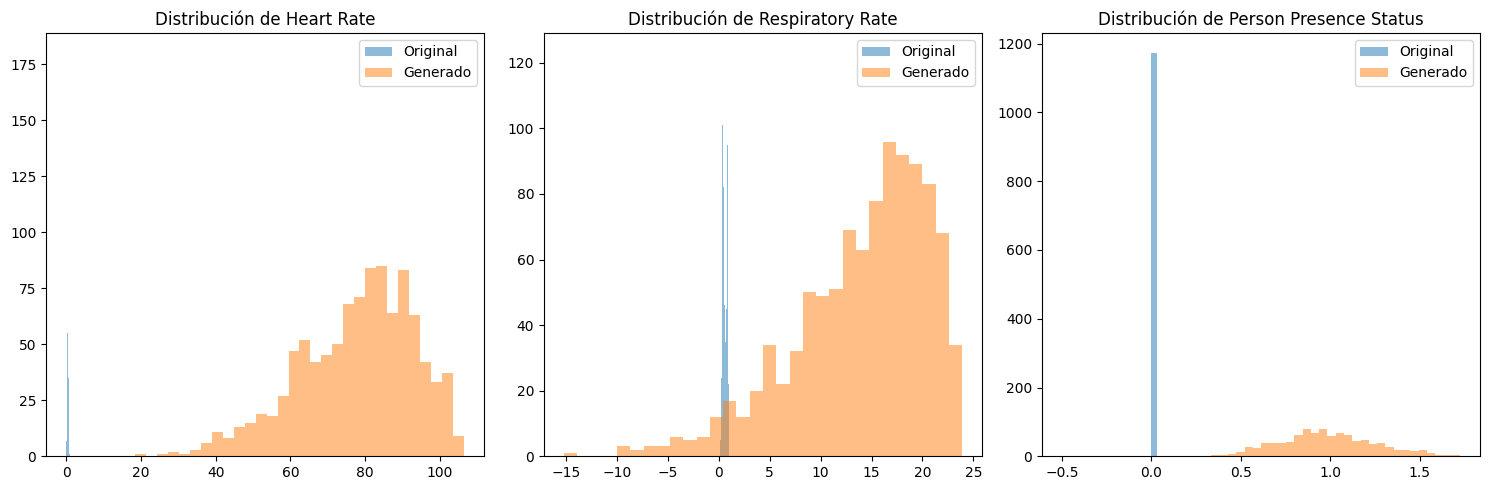

In [ ]:
import matplotlib.pyplot as plt

# Visualizar las distribuciones de las características originales y generadas
def plot_distributions(original_data, generated_data, feature_names):
    fig, axes = plt.subplots(1, len(feature_names), figsize=(15, 5))

    for i, feature in enumerate(feature_names):
        axes[i].hist(original_data[:, i], bins=30, alpha=0.5, label='Original')
        axes[i].hist(generated_data[:, i], bins=30, alpha=0.5, label='Generado')
        axes[i].set_title(f'Distribución de {feature}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

feature_names = ['Heart Rate','Respiratory Rate',	'Person Presence Status']  # Ajustar según las columnas reales
plot_distributions(X_scaled, generated_data, feature_names)


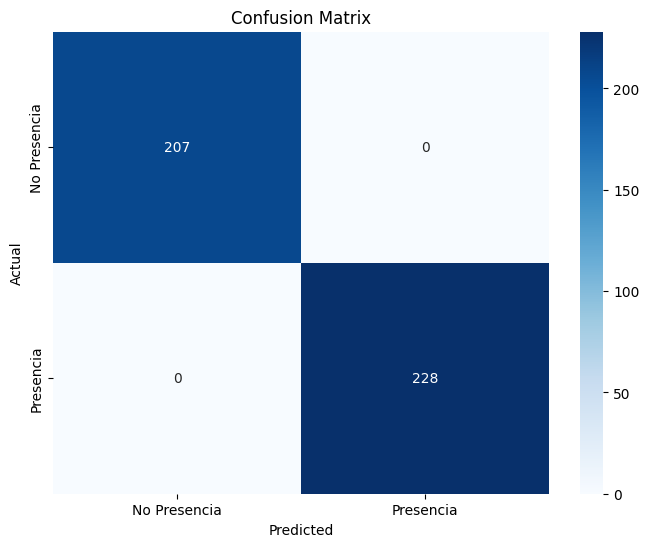

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualizar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Etiquetas de las clases (ajustar según el caso)
class_names = ['No Presencia', 'Presencia']
plot_confusion_matrix(y_test, y_pred, class_names)


## B. GAN-Based Data Augmentation and Classification Tree Modeling for Signal-Range Verification

This section describes the implementation of a Generative Adversarial Network (GAN) used to expand the available dataset of physiological measurements and to improve the performance of the classification model responsible for verifying signal ranges.

### Overview

After preprocessing the vital-sign readings (heart rate, respiratory rate and presence status) and generating the corresponding out-of-range and validity labels, the next step focuses on addressing the limited size and variability of the dataset. To do so, a GAN is trained to learn the underlying distribution of the real physiological data and to generate new synthetic samples that reproduce similar statistical properties. These synthetic samples are later incorporated into the training set of a decision-tree-based machine learning model, enhancing its robustness and generalization capabilities when detecting valid and out-of-range events.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Seleccionar las características (todas menos 'out_of_the_range_rr' y 'out_of_the_range_hr')
X = filtered_data.drop(columns=['out_of_range_hr', 'out_of_range_rr'])
y = filtered_data[['out_of_range_rr', 'out_of_range_hr']]

# Normalizar las características
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Crear una etiqueta combinada que indique si cualquier valor está fuera de rango
y_combined = np.where((y['out_of_range_rr'] == 1) | (y['out_of_range_hr'] == 1), 1, 0)


### 1. GAN Architecture

The GAN consists of two neural networks trained in opposition:

- **Generator**  
  Receives a random noise vector as input and produces synthetic samples matching the dimensionality and structure of the real data (heart rate, respiratory rate and presence).  
  It is composed of several fully connected layers with LeakyReLU activations and batch normalization to stabilize the training dynamics.

- **Discriminator**  
  Takes either real data or generator-produced data as input and outputs a probability indicating whether the sample is real or synthetic.  
  It is also implemented as a fully connected network, trained with binary cross-entropy loss to distinguish between real and generated samples.

During training, the generator aims to produce samples that the discriminator classifies as real, while the discriminator simultaneously improves its ability to detect fake samples. This adversarial process forces the generator to learn increasingly realistic representations of physiological measurements.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten

# Dimensión de entrada para el generador
latent_dim = 100

# Crear el generador
def create_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(X.shape[1], activation='tanh'))
    return model

# Crear el discriminador
def create_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=X.shape[1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compilar el modelo discriminador
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Crear el modelo combinado (discriminador no entrenable)
discriminator.trainable = False
generator = create_generator()
z = tf.keras.Input(shape=(latent_dim,))
generated_data = generator(z)
validity = discriminator(generated_data)
combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))


### 2. Training Procedure

The GAN is trained iteratively following the standard adversarial learning cycle:

1. A batch of real scaled samples is drawn from the dataset.  
2. A batch of synthetic samples is produced by feeding random noise into the generator.  
3. The discriminator is trained with both:
   - real samples (target label = 1)
   - synthetic samples (target label = 0)
4. The generator is then trained through the combined GAN model, encouraging it to generate samples that the discriminator incorrectly classifies as real.

This alternating optimization gradually improves both networks, with the discriminator learning to differentiate input samples and the generator learning to approximate the true physiological data distribution.


In [ ]:
# Parámetros de entrenamiento
epochs = 1000
batch_size = 32
save_interval = 1000

# Etiquetas para datos reales y generados
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Entrenar el discriminador con datos reales
    idx = np.random.randint(0, X_scaled.shape[0], batch_size)
    real_data = X_scaled[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, real)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, real)

    # Imprimir el progreso
    if epoch % save_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

# Guardar el generador entrenado
generator.save("generator.h5")


1/1 [==============================] - 1s 1s/step
0 [D loss: 0.6926273703575134 | D accuracy: 50.0] [G loss: 0.6464483737945557]
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 3. Synthetic Data Generation and Dataset Augmentation

Once the GAN reaches stable training performance, the generator is used to produce a large number of synthetic physiological measurements. These generated samples are:

- mapped back to the original feature scale through the inverse transformation of the previously fitted MinMaxScaler,  
- assigned appropriate class labels for training purposes,  
- and concatenated with the real dataset to form an **augmented training set**.

This augmentation mitigates issues such as class imbalance, limited representation of edge cases, and insufficient variability in physiological patterns.


In [ ]:
# Generar nuevas muestras
num_samples = 1173
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_data = generator.predict(noise)

# Invertir la normalización
generated_data = scaler.inverse_transform(generated_data)

# Crear etiquetas para los datos generados (suponiendo que son "0" para no presencia)
generated_labels = np.zeros(num_samples)

# Combinar los datos generados con los datos originales
X_augmented = np.vstack((X_scaled, generated_data))
y_augmented = np.hstack((y_combined, generated_labels))

print(X_augmented.shape)
print(y_augmented.shape)


37/37 [==============================] - 0s 6ms/step
(2346, 4)
(2346,)


### 4. Classification Tree Model for Range Verification

With the augmented dataset, a decision-tree-based machine learning model (in this implementation, a Random Forest classifier) is trained to classify signal readings into:

- **valid in-range values**,  
- **valid but out-of-range values**,  
- **invalid or noisy readings**.

The classifier benefits from the increased diversity introduced by the synthetic samples, particularly in rare or borderline scenarios where the original dataset lacked representation. Performance evaluation on the test set confirms whether the augmented dataset improves predictive accuracy and reduces misclassification rates.


In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)


In [ ]:
# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 1.0
Confusion Matrix:
[[345   0]
 [  0 125]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       345
         1.0       1.00      1.00      1.00       125

    accuracy                           1.00       470
   macro avg       1.00      1.00      1.00       470
weighted avg       1.00      1.00      1.00       470



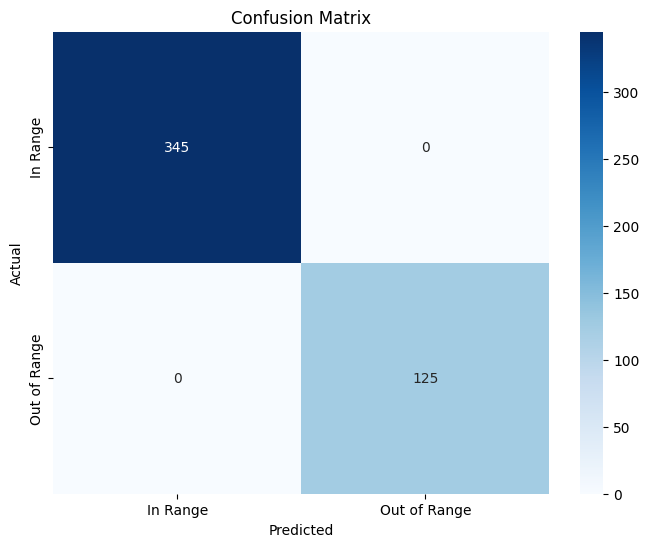

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Etiquetas de las clases
class_names = ['In Range', 'Out of Range']
plot_confusion_matrix(y_test, y_pred, class_names)


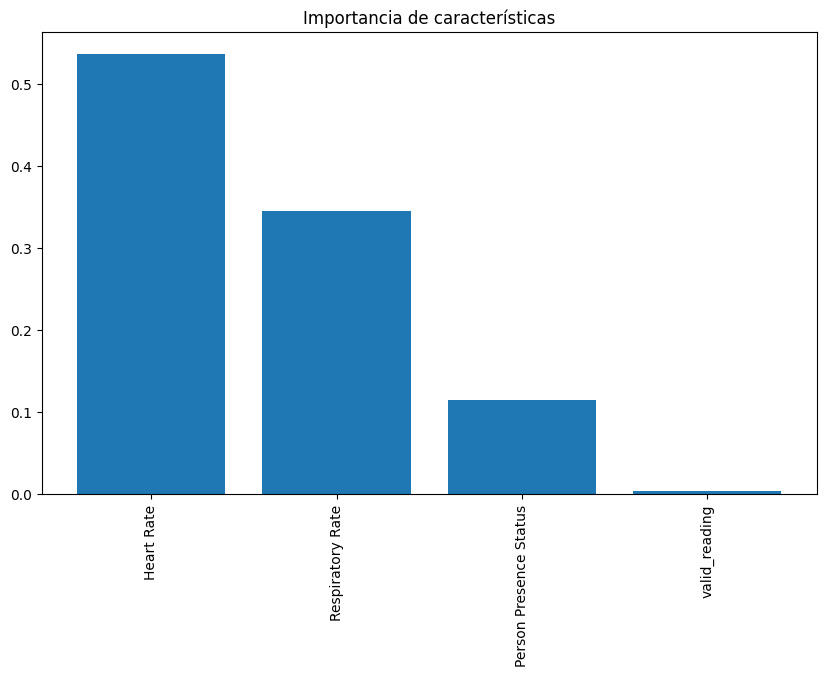

In [ ]:
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Importancia de características")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.show()

plot_feature_importances(model, X.columns)


In [ ]:
print(X_augmented)

[[1.72413793e-01 8.00000000e-01 0.00000000e+00 1.00000000e+00]
 [6.89655172e-02 7.20000000e-01 0.00000000e+00 1.00000000e+00]
 [4.65517241e-01 4.80000000e-01 0.00000000e+00 1.00000000e+00]
 ...
 [4.98381042e+01 1.99619446e+01 1.01058030e+00 9.97141659e-01]
 [1.03221748e+02 1.81992760e+01 4.62597787e-01 9.98764455e-01]
 [9.02003860e+01 1.34382515e+01 1.25357544e+00 9.90160406e-01]]



### Visualization of Vital-Sign Signals with Differentiated Color Coding

This section provides a visual analysis of the heart rate and respiratory rate signals using a color-coded scheme that reflects the out-of-range conditions detected during preprocessing.

Each sample is assigned a color according to the combination of out-of-range flags:

- **Red**: both heart rate and respiratory rate are out of range (“Fuera de Rango ambas”).
- **Orange**: only the heart rate is out of range (“Fuera de Rango (HR)” / “Fuera de Rango latidos”).
- **Yellow**: only the respiratory rate is out of range (“Fuera de Rango (RR)” / “Fuera de Rango respiración”).
- **Gray**: sample within the expected physiological range (“Dentro del rango”).

Two plots are displayed:

1. **Heart Rate (Frecuencia Cardíaca)**  
   The base signal is shown in gray, and individual points are colored depending on their out-of-range classification.  
   This helps identify sudden abnormalities or clusters of anomalous heart-rate behavior.

2. **Respiratory Rate (Frecuencia Respiratoria)**  
   Similarly, the respiratory rate is plotted with the same color-coding logic, enabling a direct visual comparison between both physiological signals.

This visualization allows the reader to:

- Detect temporal patterns of abnormal behavior.
- Identify isolated artifacts versus consistent deviation patterns.
- Validate the out-of-range logic implemented in the preprocessing step.


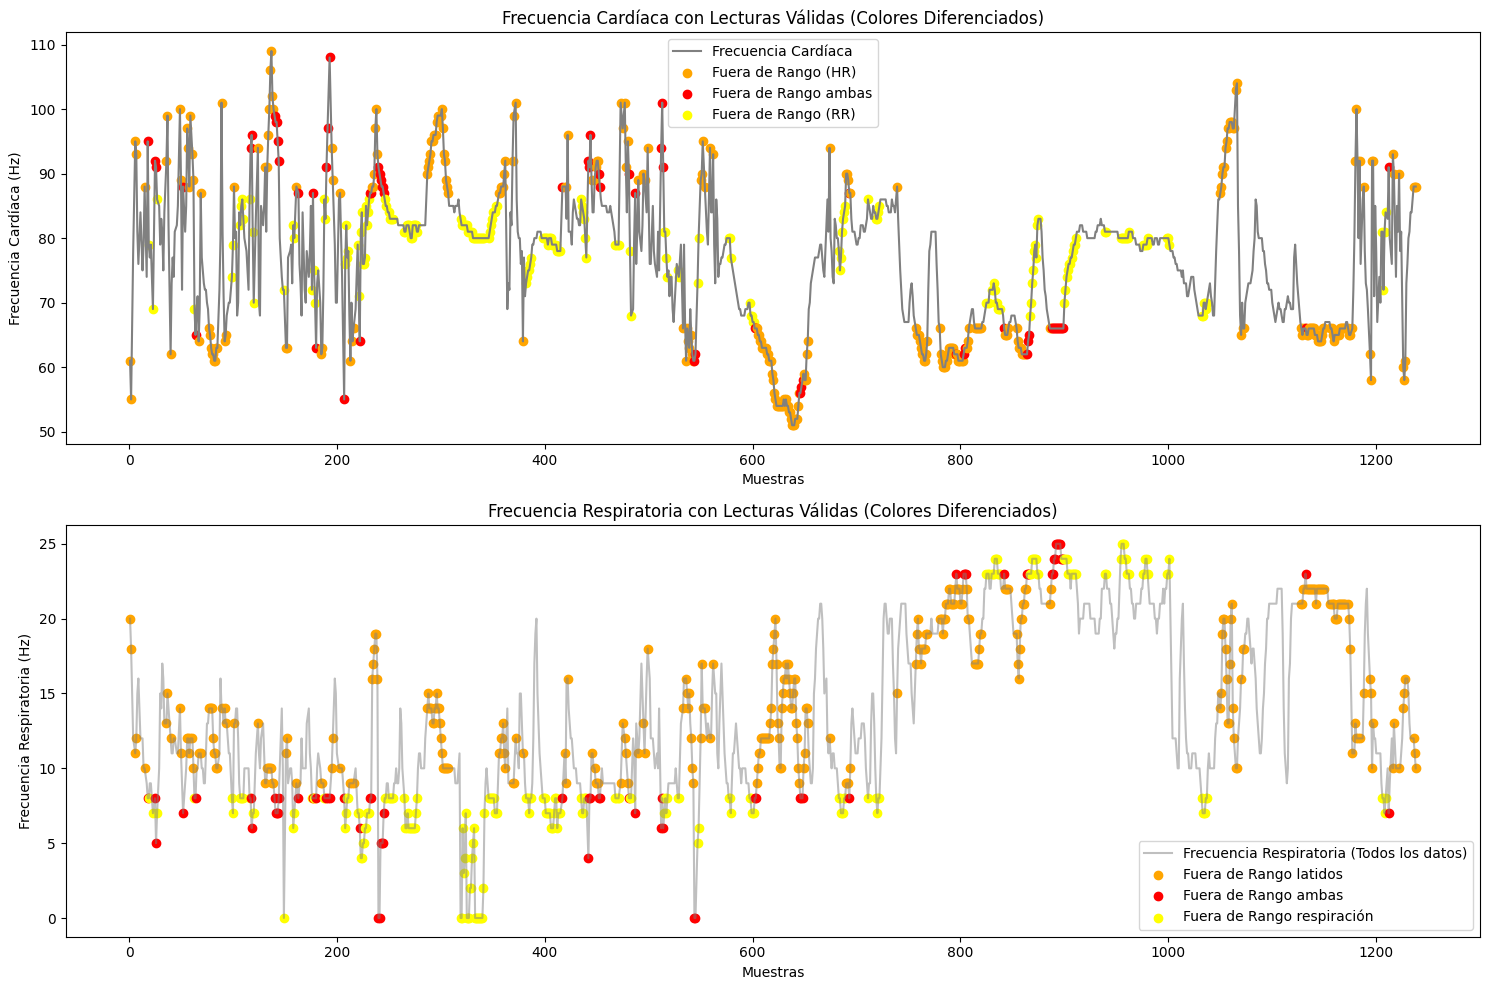

In [ ]:
# Visualización de los datos válidos con colores diferenciados
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Mantener un registro de etiquetas únicas
added_labels = set()
# Frecuencia cardíaca con lecturas válidas y colores diferenciados
axs[0].plot(filtered_data.index, filtered_data['Heart Rate'], label='Frecuencia Cardíaca', color='gray')
for idx, row in filtered_data.iterrows():
    if row['out_of_range_hr'] == 1 and row['out_of_range_rr'] == 1:
        color = 'red'  # Más alarmante
        label = 'Fuera de Rango ambas'
    elif row['out_of_range_hr'] == 1:
        color = 'orange'
        label = 'Fuera de Rango (HR)'

    elif row['out_of_range_rr'] == 1:
        color = 'yellow'
        label = 'Fuera de Rango (RR)'
    else:
        color = 'gray'
        label = 'Dentro del rango'
        continue

    if label not in added_labels:
        axs[0].scatter(idx, row['Heart Rate'],color=color, label=label)
        added_labels.add(label)
    else:
      axs[0].scatter(idx, row['Heart Rate'], color=color)


#axs[0].scatter(color=color, label=label)
axs[0].set_title('Frecuencia Cardíaca con Lecturas Válidas (Colores Diferenciados)')
axs[0].set_xlabel('Muestras')
axs[0].set_ylabel('Frecuencia Cardíaca (Hz)')
axs[0].legend()


# Visualización de la frecuencia respiratoria con lecturas válidas y colores diferenciados
added_labels = set()
axs[1].plot(filtered_data.index, filtered_data['Respiratory Rate'], label='Frecuencia Respiratoria (Todos los datos)', alpha=0.5, color='gray')
for idx, row in filtered_data.iterrows():
    if row['out_of_range_hr'] == 1 and row['out_of_range_rr'] == 1:
        color = 'red'  # Más alarmante
        label = 'Fuera de Rango ambas'
    elif row['out_of_range_hr'] == 1:
        label = 'Fuera de Rango latidos'
        color = 'orange'
    elif row['out_of_range_rr'] == 1:
        color = 'yellow'
        label = 'Fuera de Rango respiración'
    else:
        color = 'gray'
        label = 'Dentro del rango'
        continue

    if label not in added_labels:
        axs[1].scatter(idx, row['Respiratory Rate'],color=color, label=label)
        added_labels.add(label)
    else:
        axs[1].scatter(idx, row['Respiratory Rate'], color=color)

axs[1].set_title('Frecuencia Respiratoria con Lecturas Válidas (Colores Diferenciados)')
axs[1].set_xlabel('Muestras')
axs[1].set_ylabel('Frecuencia Respiratoria (Hz)')
axs[1].legend()

plt.tight_layout()
plt.show()

### Why Use a GAN Instead of Traditional Oversampling?

While methods like SMOTE create new samples based on interpolation, a GAN learns the underlying data distribution, producing more realistic and diverse synthetic examples. This is especially useful in biomedical signals where subtle variations matter.
